In [1]:
%cd '/content/drive/Othercomputers/My Laptop/MTECH_IIT/classes/4th semester/AML/project glucoma/MNet_DeepCDR'

/content/drive/Othercomputers/My Laptop/MTECH_IIT/classes/4th semester/AML/project glucoma/MNet_DeepCDR


In [2]:
_=!pip install -r requirements.txt
# _=!pip install .
_=!pip uninstall h5py
_=!pip install h5py==2.10.0

## Imports

In [3]:
import os
import json
import csv
import random
import seaborn as sns
import pickle
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage.measurements import label
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
from __future__ import print_function
from os import path
from sys import modules
from pkg_resources import resource_filename
from skimage.measure import label, regionprops
from skimage.transform import rotate, resize
from tensorflow.keras.preprocessing import image
from time import time
from tensorflow.keras.optimizers import SGD
from mnet_deep_cdr import Model_MNet as DeepModel
from mnet_deep_cdr.mnet_utils import dice_coef_loss, train_loader, mk_dir, files_with_ext
from mnet_deep_cdr import Model_DiscSeg as DiscModel
from mnet_deep_cdr.mnet_utils import BW_img, disc_crop, mk_dir, files_with_ext
from mnet_deep_cdr import Model_DiscSeg as DiscModel, Model_MNet as MNetModel
from mnet_deep_cdr.mnet_utils import pro_process, BW_img, disc_crop, mk_dir, files_with_ext
from __future__ import absolute_import
from tensorflow.keras.layers import (Input, concatenate, Conv2D, MaxPooling2D, AveragePooling2D,
                                            Conv2DTranspose, UpSampling2D, average)
from tensorflow.keras.models import Model

# from keras.preprocessing import image
from matplotlib.pyplot import imshow
from mnet_deep_cdr.mnet_utils import pro_process, BW_img, disc_crop
%matplotlib inline
from mnet_deep_cdr import Model_MNet as MNetModel

In [4]:
EPS = 1e-7

def compute_dice_coef(input, target):
    '''
    Compute dice score metric.
    '''
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())

def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=1)

    # return it
    return diameter

def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    '''
    Compute vCDR prediction error, along with predicted vCDR and ground truth vCDR.
    '''
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR

def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc

def fov_error(pred_fov, gt_fov):
    '''
    Fovea localization error metric (mean root squared error).
    '''
    err = np.sqrt(np.sum((gt_fov-pred_fov)**2, axis=1)).mean()
    return err

## Model

In [5]:
def DeepModel(size_set=800):
    img_input = Input(shape=(size_set, size_set, 3))

    scale_img_2 = AveragePooling2D(pool_size=(2, 2))(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2))(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2))(scale_img_3)

    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv1')(img_input)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    input2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_input1')(scale_img_2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv1')(input2)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block2_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    input3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_input1')(scale_img_3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv1')(input3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block3_conv2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    input4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_input1')(scale_img_4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv1')(input4)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block4_conv2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1')(pool4)
    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2')(conv5)

    up6 = concatenate(
        [Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5), conv4],
        axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block6_conv1')(up6)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu', name='block6_conv2')(conv6)

    up7 = concatenate(
        [Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6), conv3],
        axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block7_conv1')(up7)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu', name='block7_conv2')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7), conv2],
                      axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv1')(up8)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv2')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8), conv1],
                      axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv1')(up9)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv2')(conv9)

    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(2, (1, 1), activation='sigmoid', name='side_63')(side6)
    out7 = Conv2D(2, (1, 1), activation='sigmoid', name='side_73')(side7)
    out8 = Conv2D(2, (1, 1), activation='sigmoid', name='side_83')(side8)
    out9 = Conv2D(2, (1, 1), activation='sigmoid', name='side_93')(conv9)

    out10 = average([out6, out7, out8, out9])

    return Model(inputs=[img_input], outputs=[out6, out7, out8, out9, out10])

model = DeepModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 800, 800, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 400, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 800, 800, 32) 9248        block1_conv1[0][0]               
______________________________________________________________________________________________

In [6]:
!ls -lrth '/content/drive/MyDrive/DatasetCollection/Glaucoma/refuge_data/'

total 74M
drwx------ 2 root root 4.0K Sep 20 16:07 test
drwx------ 2 root root 4.0K Sep 20 16:07 train
drwx------ 2 root root 4.0K Sep 20 16:09 val
-rw------- 1 root root 9.8M Nov 29 11:38 base_pirl_memory.pt
-rw------- 1 root root  24M Nov 29 11:38 finetuned_pirl.pt
-rw------- 1 root root  41M Nov 29 11:38 base_pirl.pt
drwx------ 2 root root 4.0K Nov 29 12:57 store


## Step 1 : Cropping the Optic Disk Part

In [9]:
# for training part
enabled_crop=False

disc_list = [400, 500, 600, 700, 800]
DiscROI_size = 800
DiscSeg_size = 640
CDRSeg_size = 400

if enabled_crop:
  data_type = '.jpg'
  parent_dir = path.dirname(resource_filename(modules[__name__].__name__, '__init__.py'))
  data_img_path = path.abspath(path.join(parent_dir, 'data', 'REFUGE-Training400', 'Training400', 'Glaucoma'))
  label_img_path = path.abspath(path.join(parent_dir, 'data', 'Annotation-Training400',
                                          'Annotation-Training400', 'Disc_Cup_Masks', 'Glaucoma'))
  data_set_parent_dir='/content/drive/MyDrive/DatasetCollection/Glaucoma/refuge_data'

  data_img_path = path.join(data_set_parent_dir, 'train','images')
  label_img_path = path.join(data_set_parent_dir, 'train','gts')

  data_save_path = mk_dir(path.join(parent_dir, 'training_crop', 'data'))
  label_save_path = mk_dir(path.join(parent_dir, 'training_crop', 'label'))

  file_test_list = files_with_ext(data_img_path, data_type)

  DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
  DiscSeg_model.load_weights(path.join(parent_dir, 'deep_model', 'Model_DiscSeg_ORIGA.h5'))

  Disc_flat = None

  for lineIdx, temp_txt in enumerate(file_test_list):
      #print('Processing Img {idx}: {temp_txt}'.format(idx=lineIdx + 1, temp_txt=temp_txt))

      # load image
      org_img = np.asarray(image.load_img(path.join(data_img_path, temp_txt)))

      # load label
      org_label = np.asarray(image.load_img(path.join(label_img_path, temp_txt[:-4] + '.bmp')))[:, :, 0]
      new_label = np.zeros(np.shape(org_label) + (3,), dtype=np.uint8)
      new_label[org_label < 200, 0] = 255
      new_label[org_label < 100, 1] = 255

      # Disc region detection by U-Net
      temp_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3)) * 255
      temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
      disc_map = DiscSeg_model.predict([temp_img])

      disc_map = BW_img(np.reshape(disc_map, (DiscSeg_size, DiscSeg_size)), 0.5)

      regions = regionprops(label(disc_map))
      C_x = int(regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size)
      C_y = int(regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size)

      for disc_idx, DiscROI_size in enumerate(disc_list):
          disc_region, err_coord, crop_coord = disc_crop(org_img, DiscROI_size, C_x, C_y)
          label_region, _, _ = disc_crop(new_label, DiscROI_size, C_x, C_y)
          Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size / 2, DiscROI_size / 2), DiscROI_size / 2,
                                            cv2.INTER_NEAREST + cv2.WARP_FILL_OUTLIERS), -90)
          Label_flat = rotate(cv2.linearPolar(label_region, (DiscROI_size / 2, DiscROI_size / 2), DiscROI_size / 2,
                                              cv2.INTER_NEAREST + cv2.WARP_FILL_OUTLIERS), -90)

          disc_result = Image.fromarray((Disc_flat * 255).astype(np.uint8))
          filename = '{}_{}.png'.format(temp_txt[:-4], DiscROI_size)
          disc_result.save(path.join(data_save_path, filename))
          label_result = Image.fromarray((Label_flat * 255).astype(np.uint8))
          label_result.save(path.join(label_save_path, filename))

  plt.imshow(Disc_flat)
  plt.show()

In [10]:
# for validation set
if enabled_crop:
  data_set_parent_dir='/content/drive/MyDrive/DatasetCollection/Glaucoma/refuge_data'

  data_img_path = path.join(data_set_parent_dir, 'val','images')
  label_img_path = path.join(data_set_parent_dir, 'val','gts')

  data_save_path = mk_dir(path.join(parent_dir, 'val_data', 'data'))
  label_save_path = mk_dir(path.join(parent_dir, 'val_data', 'label'))

  file_test_list = files_with_ext(data_img_path, data_type)

  DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
  DiscSeg_model.load_weights(path.join(parent_dir, 'deep_model', 'Model_DiscSeg_ORIGA.h5'))

  Disc_flat = None

  for lineIdx, temp_txt in enumerate(file_test_list):
      #print('Processing Img {idx}: {temp_txt}'.format(idx=lineIdx + 1, temp_txt=temp_txt))

      # load image
      org_img = np.asarray(image.load_img(path.join(data_img_path, temp_txt)))

      # load label
      org_label = np.asarray(image.load_img(path.join(label_img_path, temp_txt[:-4] + '.bmp')))[:, :, 0]
      new_label = np.zeros(np.shape(org_label) + (3,), dtype=np.uint8)
      new_label[org_label < 200, 0] = 255
      new_label[org_label < 100, 1] = 255

      # Disc region detection by U-Net
      temp_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3)) * 255
      temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
      disc_map = DiscSeg_model.predict([temp_img])

      disc_map = BW_img(np.reshape(disc_map, (DiscSeg_size, DiscSeg_size)), 0.5)

      regions = regionprops(label(disc_map))
      C_x = int(regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size)
      C_y = int(regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size)

      for disc_idx, DiscROI_size in enumerate(disc_list):
          disc_region, err_coord, crop_coord = disc_crop(org_img, DiscROI_size, C_x, C_y)
          label_region, _, _ = disc_crop(new_label, DiscROI_size, C_x, C_y)
          Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size / 2, DiscROI_size / 2), DiscROI_size / 2,
                                            cv2.INTER_NEAREST + cv2.WARP_FILL_OUTLIERS), -90)
          Label_flat = rotate(cv2.linearPolar(label_region, (DiscROI_size / 2, DiscROI_size / 2), DiscROI_size / 2,
                                              cv2.INTER_NEAREST + cv2.WARP_FILL_OUTLIERS), -90)

          disc_result = Image.fromarray((Disc_flat * 255).astype(np.uint8))
          filename = '{}_{}.png'.format(temp_txt[:-4], DiscROI_size)
          disc_result.save(path.join(data_save_path, filename))
          label_result = Image.fromarray((Label_flat * 255).astype(np.uint8))
          label_result.save(path.join(label_save_path, filename))

  plt.imshow(Disc_flat)
  plt.show()


## Step 2 : Training

In [ ]:
parent_dir = path.dirname(resource_filename(modules[__name__].__name__, '__init__.py'))
result_path = mk_dir(path.join(parent_dir, 'deep_model'))
pre_model_file = path.join(parent_dir, 'deep_model', 'Model_MNet_REFUGE.h5')
save_model_file = path.join(parent_dir, 'deep_model', 'Model_MNet_REFUGE_v2.h5')

root_path = path.join(parent_dir, 'training_crop')
train_data_path = path.join(root_path, 'data')
train_mask_path = path.join(root_path, 'label')

val_data_path = path.join(parent_dir, 'val_data', 'data')
val_mask_path = path.join(parent_dir, 'val_data', 'label')

# load training data
train_list = files_with_ext(train_data_path, '.png')
val_list = files_with_ext(val_data_path, '.png')

Total_iter = 100
nb_epoch_setting = 3
input_size = 400
optimizer_setting = SGD(learning_rate=0.0001, momentum=0.9)

my_model = DeepModel.DeepModel(size_set=input_size)
my_model.load_weights(pre_model_file, by_name=True)

my_model.compile(optimizer=optimizer_setting, loss=dice_coef_loss, loss_weights=[0.1, 0.1, 0.1, 0.1, 0.6])

loss_max = 10000

for idx_iter in range(Total_iter):
    random.shuffle(train_list)
    model_return = my_model.fit_generator(
        generator=train_loader(train_list, train_data_path, train_mask_path, input_size),
        steps_per_epoch=len(train_list),
        validation_data=train_loader(val_list, val_data_path, val_mask_path, input_size),
        validation_steps=len(train_list),
        verbose=0
    )
    val_loss = model_return.history['val_loss'][0]
    train_loss = model_return.history['loss'][0]
    if val_loss < loss_max:
        my_model.save(save_model_file)
        loss_max = val_loss
        print('[Save] training iter: {idx}, train_loss: {train_loss}, val_loss: {val_loss}'.format(
            idx=idx_iter + 1, train_loss=train_loss, val_loss=val_loss)
        )
    else:
        print('[None] training iter: {idx}, train_loss: {train_loss}, val_loss: {val_loss}'.format(
            idx=idx_iter + 1, train_loss=train_loss, val_loss=val_loss)
        )


## Step 3: Testing

In [1]:

DiscROI_size = 600
DiscSeg_size = 640
CDRSeg_size = 400

parent_dir = path.dirname(resource_filename(modules[__name__].__name__, '__init__.py'))
data_set_parent_dir='/content/drive/MyDrive/DatasetCollection/Glaucoma/refuge_data'

test_data_path = path.join(data_set_parent_dir, 'test','images')
data_save_path = mk_dir(path.join(parent_dir, 'test_img'))

file_test_list = files_with_ext(test_data_path, '.jpg')

DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
DiscSeg_model.load_weights(path.join(parent_dir, 'deep_model', 'Model_DiscSeg_ORIGA.h5'))

CDRSeg_model = MNetModel.DeepModel(size_set=CDRSeg_size)
CDRSeg_model.load_weights(path.join(parent_dir, 'deep_model', 'Model_MNet_REFUGE_v2.h5'))

for lineIdx, temp_txt in enumerate(file_test_list):
    # load image
    org_img = np.asarray(image.load_img(path.join(test_data_path, temp_txt)))
    # Disc region detection by U-Net
    temp_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3)) * 255
    temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
    disc_map = DiscSeg_model.predict([temp_img])
    disc_map = BW_img(np.reshape(disc_map, (DiscSeg_size, DiscSeg_size)), 0.5)

    regions = regionprops(label(disc_map))
    C_x = int(regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size)
    C_y = int(regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size)
    disc_region, err_xy, crop_xy = disc_crop(org_img, DiscROI_size, C_x, C_y)

    # Disc and Cup segmentation by M-Net
    run_start = time()
    Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size / 2, DiscROI_size / 2),
                                       DiscROI_size / 2, cv2.WARP_FILL_OUTLIERS), -90)

    temp_img = pro_process(Disc_flat, CDRSeg_size)
    temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
    [_, _, _, _, prob_10] = CDRSeg_model.predict(temp_img)
    run_end = time()

    # Extract mask
    prob_map = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
    disc_map = np.array(Image.fromarray(prob_map[:, :, 0]).resize((DiscROI_size, DiscROI_size)))
    cup_map = np.array(Image.fromarray(prob_map[:, :, 1]).resize((DiscROI_size, DiscROI_size)))
    disc_map[-round(DiscROI_size / 3):, :] = 0
    cup_map[-round(DiscROI_size / 2):, :] = 0
    De_disc_map = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size / 2, DiscROI_size / 2),
                                  DiscROI_size / 2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
    De_cup_map = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size / 2, DiscROI_size / 2),
                                 DiscROI_size / 2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)

    De_disc_map = np.array(BW_img(De_disc_map, 0.5), dtype=int)
    De_cup_map = np.array(BW_img(De_cup_map, 0.5), dtype=int)

    print('Processing Img {idx}: {temp_txt}, running time: {running_time}'.format(
        idx=lineIdx + 1, temp_txt=temp_txt, running_time=run_end - run_start
    ))

    # Save raw mask
    ROI_result = np.array(BW_img(De_disc_map, 0.5), dtype=int) + np.array(BW_img(De_cup_map, 0.5), dtype=int)
    Img_result = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.int8)
    Img_result[crop_xy[0]:crop_xy[1], crop_xy[2]:crop_xy[3], ] = ROI_result[err_xy[0]:err_xy[1], err_xy[2]:err_xy[3], ]
    save_result = Image.fromarray((Img_result * 127).astype(np.uint8))
    save_result.save(path.join(data_save_path, temp_txt[:-4] + '.png'))


Train Loss: 0.9560
Val Loss: 0.9450
OD segmentation (Dice Score): 0.8790
OC segmentation (Dice Score): 0.7677
vCDR error: 0.2149
Classification (AUC): 0.9060


## Result Validation for single Image


In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


DiscROI_size = 800
DiscSeg_size = 640
CDRSeg_size = 400

_parent_dir = path.dirname(resource_filename(modules[__name__].__name__, '__init__.py'))
data_img_path = path.join(_parent_dir, 'test_img')
print('_parent_dir',_parent_dir)
DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
DiscSeg_model.load_weights(path.join(_parent_dir, 'Model_DiscSeg_ORIGA.h5'))

CDRSeg_model = MNetModel.DeepModel(size_set=CDRSeg_size)
CDRSeg_model.load_weights(path.join(_parent_dir, 'Model_MNet_REFUGE.h5'))

_parent_dir 


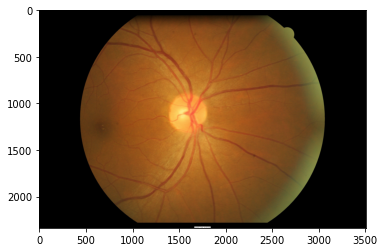

In [9]:
img_name = 'CS50106_R.jpg'

org_img = np.asarray(image.load_img(path.join('mnet_deep_cdr/'+data_img_path, img_name)))
imshow(org_img)

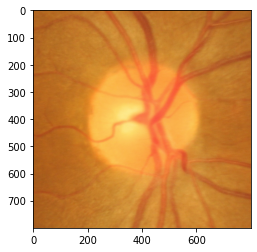

In [10]:
temp_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3))*255
temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
# [prob_6, prob_7, prob_8, prob_9, prob_10] = DiscSeg_model.predict([temp_img])
prob_10 = DiscSeg_model.predict([temp_img])

disc_map = BW_img(np.reshape(prob_10, (DiscSeg_size, DiscSeg_size)), 0.5)

regions = regionprops(label(disc_map))
C_x = regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size
C_y = regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size

disc_region, err_coord, crop_coord = disc_crop(org_img, DiscROI_size, C_x, C_y)
imshow(disc_region)

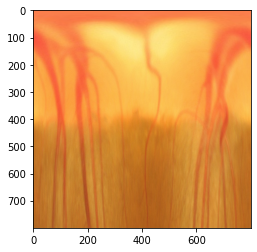

In [11]:
Disc_flat = rotate(cv2.linearPolar(disc_region, (DiscROI_size/2, DiscROI_size/2), DiscROI_size/2, cv2.WARP_FILL_OUTLIERS), -90)
imshow(Disc_flat)

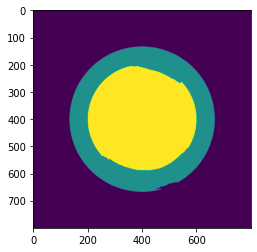

In [12]:
temp_img = pro_process(Disc_flat, CDRSeg_size)
temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
[prob_6, prob_7, prob_8, prob_9, prob_10] = CDRSeg_model.predict(temp_img)
prob_map = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
disc_map = resize(prob_map[:, :, 0], (DiscROI_size, DiscROI_size))
cup_map = resize(prob_map[:, :, 1], (DiscROI_size, DiscROI_size))
disc_map[-round(DiscROI_size / 3):, :] = 0
cup_map[-round(DiscROI_size / 2):, :] = 0

De_disc_map = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                  DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
De_cup_map = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                 DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)


De_disc_map = np.array(BW_img(De_disc_map, 0.5), dtype=int)
De_cup_map = np.array(BW_img(De_cup_map, 0.5), dtype=int)


ROI_result = np.array(BW_img(De_disc_map, 0.5), dtype=int) + np.array(BW_img(De_cup_map, 0.5), dtype=int)
imshow(ROI_result)

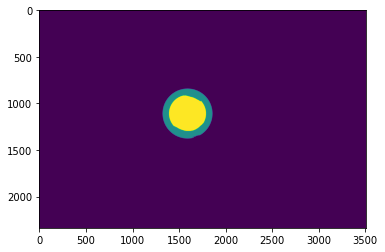

In [13]:
Img_result = np.zeros((org_img.shape[0],org_img.shape[1]), dtype=int)
Img_result_od = np.zeros((org_img.shape[0],org_img.shape[1]), dtype=int)
Img_result_oc = np.zeros((org_img.shape[0],org_img.shape[1]), dtype=int)

Img_result[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ] = ROI_result[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ]
Img_result_od[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ] = De_disc_map[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3],]
Img_result_oc[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ] = De_cup_map[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ]

imshow(Img_result)

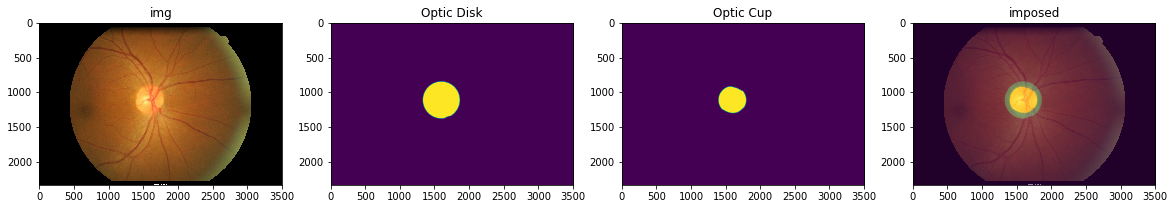

In [14]:
  im = org_img
  gt = Img_result
  im2display = im
  # im2display = im.transpose((1,2,0))
  # gt2display = gt.transpose((1,2,0))

  fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4,figsize=(20,10))
  ax1.imshow(im2display, interpolation='nearest')
  ax1.title.set_text("img")
  ax1.grid(False)
  ax2.imshow(Img_result_od)
  ax2.title.set_text("Optic Disk")
  ax2.grid(False)
  ax3.imshow(Img_result_oc)
  ax3.title.set_text("Optic Cup")
  ax3.grid(False)
  
  ax4.imshow(im2display, interpolation='nearest')
  ax4.imshow(gt, alpha=0.5)
  # ax4.imshow(gt[1], alpha=0.5)
  ax4.title.set_text("imposed")
  ax4.grid(False)
  
  plt.show()

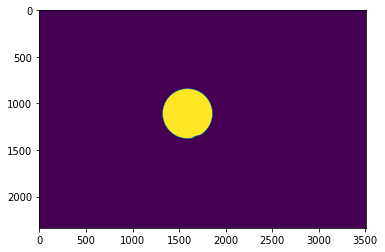

In [17]:
plt.imshow(Img_result_od)
plt.grid(False)
plt.show()

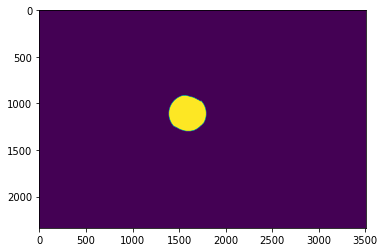

In [18]:
plt.imshow(Img_result_oc)
plt.grid(False)
plt.show()

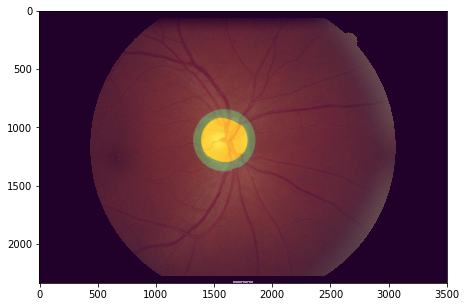

In [20]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(im2display, interpolation='nearest')
ax.imshow(gt, alpha=0.5)
ax.grid(False)  
plt.show()